In [5]:
import numpy as np
import os
from matplotlib import pyplot as plt
import cv2
import random
import pandas as pd
import pickle

file_list = []
class_list = []

DATADIR = "."

# All the categories I want my neural network to detect
CATEGORIES = ["deer","brown bear","snowshoe hare brown","Moose","human"]

# The size of the images that my neural network will use
IMG_SIZE = 50

# Checking or all images in the data folder
for category in CATEGORIES :
    path = os.path.join(DATADIR, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)

training_data = []

def create_training_data():
    for category in CATEGORIES :
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try :
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass

create_training_data()

random.shuffle(training_data) #to avoid overfitting

X = [] #features
y = [] #labels

for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1) #-1 is unknown dimension

# Creating the files containing all the information about my model
pickle_out = open("X.pickle", "wb") #wb for write buffer
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

pickle_in = open("X.pickle", "rb") #rb for read buffer
X = pickle.load(pickle_in)

Train on 531 samples, validate on 59 samples
Epoch 1/40
531/531 [==============================] - 5s 9ms/step - loss: 1.6653 - acc: 0.5669 - val_loss: 1.3359 - val_acc: 0.5932
Epoch 2/40
531/531 [==============================] - 2s 4ms/step - loss: 1.1653 - acc: 0.6083 - val_loss: 1.3075 - val_acc: 0.5932
Epoch 3/40
531/531 [==============================] - 2s 4ms/step - loss: 1.1022 - acc: 0.6083 - val_loss: 1.2314 - val_acc: 0.5932
Epoch 4/40
531/531 [==============================] - 2s 4ms/step - loss: 1.0781 - acc: 0.6083 - val_loss: 1.1601 - val_acc: 0.5932
Epoch 5/40
531/531 [==============================] - 2s 4ms/step - loss: 0.9861 - acc: 0.6365 - val_loss: 1.1399 - val_acc: 0.5932
Epoch 6/40
531/531 [==============================] - 2s 4ms/step - loss: 0.8859 - acc: 0.6629 - val_loss: 1.1195 - val_acc: 0.5932
Epoch 7/40
531/531 [==============================] - 2s 4ms/step - loss: 0.8203 - acc: 0.6893 - val_loss: 1.1195 - val_acc: 0.5932
Epoch 8/40
531/531 [===========

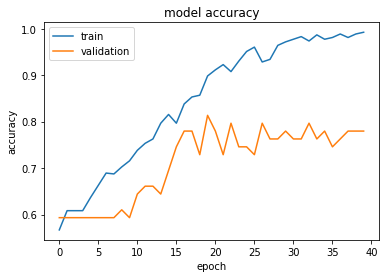

In [6]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import pickle
from keras.models import model_from_json
from keras.models import load_model
import matplotlib.pyplot as plt

# Opening the files about data
X = pickle.load(open("X.pickle", "rb"))
y = pickle.load(open("y.pickle", "rb"))

# normalizing data (a pixel goes from 0 to 255)
X = X/255.0

# Building the model
model = Sequential()
# 3 convolutional layers
model.add(Conv2D(32, (3, 3), input_shape = X.shape[1:]))
model.add(Activation("relu")) #nonlinear activation functions are important because the function you are trying to learn is usually nonlinear. If nonlinear activation functions weren’t used, the net would be a large linear classifier, and could be simplified by simply multiplying the weight matrices together (accounting for bias). It wouldn’t be able to do anything interesting, such as image classification or text prediction.
model.add(MaxPooling2D(pool_size=(2,2))) #Pooling layers are used to generalize the output of the convolutional layers. Along with generalizing, it also reduces the number of parameters in the model by down-sampling the output of the convolutional layer.

model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2 hidden layers
model.add(Flatten()) #Flatten layer converts the output of convolutional layers into a one dimensional feature vector. It is important to flatten the outputs because Dense (Fully connected) layers only accept a feature vector as input.
model.add(Dense(5))
model.add(Activation("relu"))

model.add(Dense(5))
model.add(Activation("relu"))

# The output layer with 5 neurons, for 5 classes
model.add(Dense(5))
model.add(Activation("softmax"))

# Compiling the model using some basic parameters
model.compile(loss="sparse_categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

# Training the model, with 40 iterations
# validation_split corresponds to the percentage of images used for the validation phase compared to all the images
history = model.fit(X, y, batch_size=32, epochs=40, validation_split=0.1)

# Saving the model
model_json = model.to_json()
with open("model.json", "w") as json_file :
    json_file.write(model_json)

model.save_weights("model.h5")
print("Saved model to disk")

model.save('CNN.model')

# Printing a graph showing the accuracy changes during the training phase
print(history.history.keys())
plt.figure(1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')



In [7]:
import cv2
import tensorflow as tf
CATEGORIES = ["deer","brown bear","snowshoe hare brown","Moose","human"]

#Preaparing the image for prediction
def prepare(file):
    IMG_SIZE = 50
    img_array = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

#Predicting the animal in the image
def predict(path,count):
    print(path)
    df.at[count, 'Filename'] = path
    model = tf.keras.models.load_model("CNN.model")
    image = prepare(path)
    prediction = model.predict([image])
    print(prediction)
    prediction = list(prediction[0])
    df.at[count, 'Predicted Label'] = CATEGORIES[prediction.index(max(prediction))]
#     pd.concat([df,pd.DataFrame([[CATEGORIES[prediction.index(max(prediction))]]], columns=[1] )], axis=0)
    
df = pd.DataFrame(columns = ['Filename', 'Predicted Label']) 
count=0
for filename in os.listdir('test'):
    predict(os.path.join('test',filename),count)
    count+=1

print(df)


test/human2.jpg
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
test/deer2.jpg
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
test/moose.jpeg
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
test/snowshoe hare brown2.jpg
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
test/snowshoe hare brown.jpg
[[4.268976e-15 0.000000e+00 0.000000e+00 0.000000e+00 1.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00]]
test/human.jpg
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
                        Filename      Predicted Label
0                test/human2.jpg                human
1                 test/deer2.jpg                 deer
2                test/moose.jpeg                Moose
3  test/snowshoe hare brown2.jpg  snowshoe hare brown
4   test/snowshoe hare brown.jpg                human
5                 test/human.jpg                human


In [8]:
import cv2
import tensorflow as tf
CATEGORIES = ["deer","brown bear","snowshoe hare brown","Moose","human"]

#Preparing the image for prediction
def prepare(file):
    IMG_SIZE = 50
    img_array = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

#Predicting the animal in the image
def predict(path,count):
    df.at[count, 'Filename'] = path
    model = tf.keras.models.load_model("CNN.model")
    image = prepare(path)
    prediction = model.predict([image])
    prediction = list(prediction[0])
    df.at[count, 'Predicted Label'] = CATEGORIES[prediction.index(max(prediction))]
#   pd.concat([df,pd.DataFrame([[CATEGORIES[prediction.index(max(prediction))]]], columns=[1] )], axis=0)
    
df = pd.DataFrame(columns = ['Filename', 'Predicted Label']) 
count=0
for filename in os.listdir('Wildlife'):
    predict(os.path.join('Wildlife',filename),count)
    count+=1
    print(df)

                Filename Predicted Label
0  Wildlife/11090008.JPG            deer
                Filename      Predicted Label
0  Wildlife/11090008.JPG                 deer
1  Wildlife/09110456.JPG  snowshoe hare brown
                Filename      Predicted Label
0  Wildlife/11090008.JPG                 deer
1  Wildlife/09110456.JPG  snowshoe hare brown
2  Wildlife/06170241.JPG                human
                Filename      Predicted Label
0  Wildlife/11090008.JPG                 deer
1  Wildlife/09110456.JPG  snowshoe hare brown
2  Wildlife/06170241.JPG                human
3  Wildlife/07050290.JPG                Moose
                Filename      Predicted Label
0  Wildlife/11090008.JPG                 deer
1  Wildlife/09110456.JPG  snowshoe hare brown
2  Wildlife/06170241.JPG                human
3  Wildlife/07050290.JPG                Moose
4  Wildlife/08050373.JPG                 deer
                Filename      Predicted Label
0  Wildlife/11090008.JPG                 dee

KeyboardInterrupt: 